# Automatyczna klasyfikacja terenu z wykorzystaniem uczenia maszynowego

Zrodlo danych: Sentinel T34UDE_20200815T095039
Kroki wykonane przed analizą:
* Zmiana formatu warstw z jp2 na png ze względu na bezproblemową współpracę z OpenCV
* Klasyfikacja terenu z QGIS oraz wtyczkę QuickOSM
 ** water
 ** forest
 ** farmland
* Dla każdego typu terenu utworzono maskę w formie obrazu PNG o rozdzielczości zgodnej z danymi wejściowymi
* Utworzenie pliku konfiguracyjnego config.ini

#### Wczytanie bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from configparser import ConfigParser

In [2]:
import preprocesing as pre
import helpers as hlp

#### Wczytanie danyc z pliku konfiguracyjnego

In [3]:
config = ConfigParser()
config.read('config.ini')
input_dir = config['main']['input_dir']# Folder ze zdjęciami z Sentinela
classes_file = config['main']['classification_data']# Folder z maskami klas

Zdjęcia o rozdzielczości 10m składają sie z ponad 100 milionów pikseli
zatem do analizy wykorzystam tylko jego fragment o rozmiarze dx na dy
i zaczynający się od piksela (x_star, y_start)

In [4]:
dx = int(config['main']['x_size'])
dy = int(config['main']['y_size'])
x_start = int(config['main']['x_start'])
y_start = int(config['main']['y_start'])
csv_data_file = config['main']['csv_data_file']

#### Przekształcamy dane wejściowe w coś przyjemniejszego do analizy

In [5]:
data, columns_names = pre.images_to_numpy(input_dir, dx, dy, x_start, y_start)

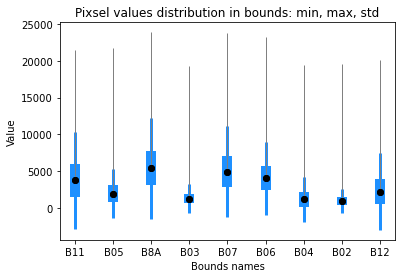

In [6]:
hlp.plot_MinMaxAvg(data, columns_names)

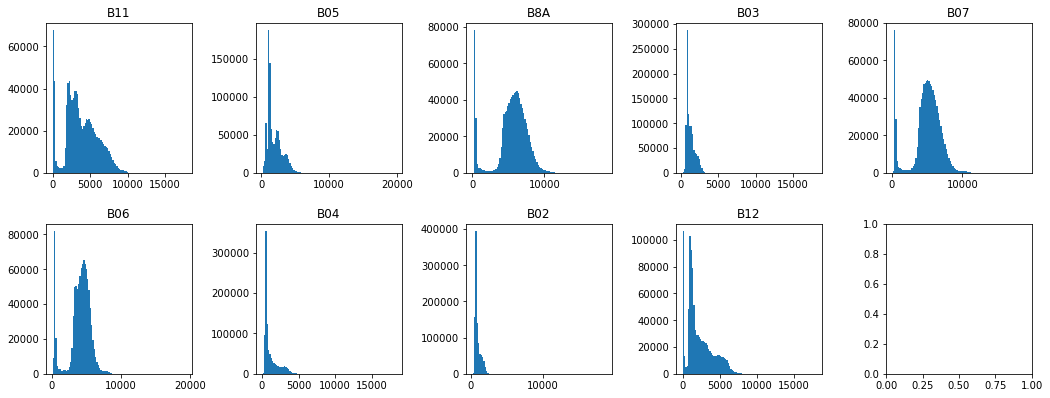

In [7]:
hlp.plot_values_histogram(data, columns_names, ncols=5)

Rozkład wartości pikseli wskazuje na występowanie wartości odstających zatem przekształćmy je w następujący sposób: $ x = min(x,\overline{x}+3\sigma_{x}) $ oraz przeskalujmy z wykorzystaniem minmaxscaler z sklearn.

In [8]:
data = pre.remove_outstandings(data)

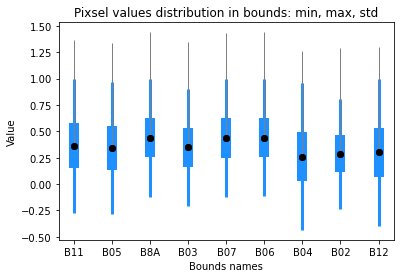

In [9]:
hlp.plot_MinMaxAvg(data, columns_names)

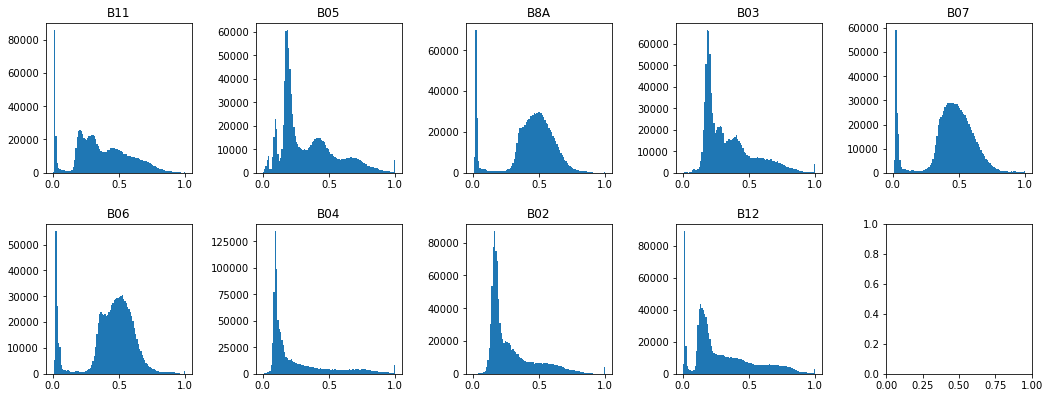

In [10]:
hlp.plot_values_histogram(data, columns_names, ncols=5)

#### Wczytajmy teraz maski klas oraz stwórzmy klasę "other"

In [11]:
classes, classes_names = pre.get_classes(classes_file, dx, dy, x_start, y_start)
other = (1 - classes.any(axis=1).astype(int)).reshape(-1, 1)
classes_names += ['other']
pre.add_classes_to_config(config, classes_names)
columns_names += classes_names 
nr_of_classes = len(classes_names)

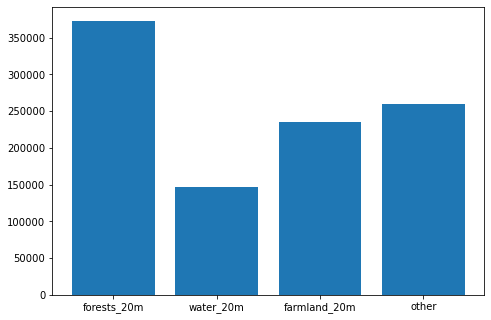

In [12]:
hlp.show_classes_distribution(np.concatenate((classes, other), axis=1), classes_names)

In [13]:
data = np.concatenate((data, classes, other), axis=1)
data = pd.DataFrame(data, columns=columns_names)
data[classes_names] = data[classes_names].astype('int')

In [14]:
data.head()

,B11,B05,B8A,B03,B07,B06,B04,B02,B12,forests_20m,water_20m,farmland_20m,other
0,0.445161,0.407560,0.629164,0.403386,0.644112,0.644603,0.221875,0.304345,0.333658,0,0,0,1
1,0.443222,0.397696,0.622152,0.401412,0.638127,0.645283,0.223822,0.312799,0.329356,0,0,0,1
2,0.436436,0.389017,0.645472,0.398121,0.659525,0.669970,0.211171,0.303499,0.319946,0,0,0,1
3,0.432752,0.371262,0.665205,0.377064,0.688902,0.672915,0.185869,0.289973,0.313762,0,0,0,1
4,0.439538,0.384282,0.645635,0.400095,0.665147,0.662043,0.209225,0.295045,0.319946,0,0,0,1


Dane zostały przygotowane zapisujemy je i możemy zająć się klasyfikacją

In [15]:
data.to_csv(csv_data_file)

Zwalniamy trochę pamięci

In [16]:
del classes
del other

#### Dzielimy dane

In [17]:
X = data.iloc[:,1:-nr_of_classes].to_numpy()
Y = data.iloc[:,-nr_of_classes:].to_numpy()
xyz = (dx,dy,nr_of_classes)
del data

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Klasyfikacja obszaru z wykorzystaniem lasów losowych

#### Trenowanie

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier()

#### Testowanie

In [20]:
Y_pred_RF = clf.predict(X_test)

In [21]:
print("Random forest acc: ",accuracy_score(Y_test, Y_pred_RF))

Random forest acc:  0.8037833333333333


#### Wizualizacja wyników

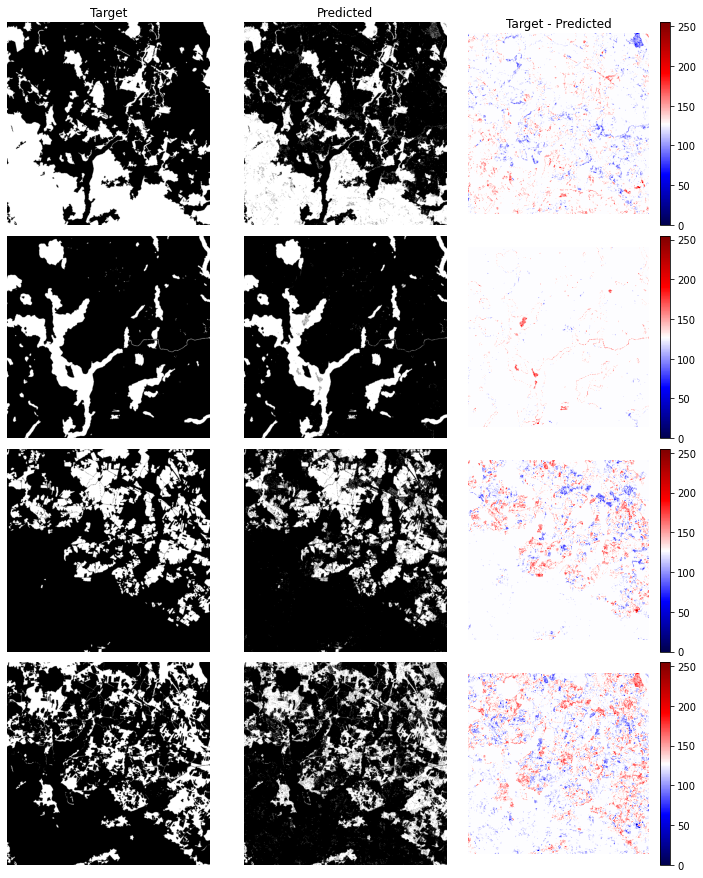

In [22]:
Y_pred_RF = clf.predict(X)
Y_pred_RF = np.rint(Y_pred_RF)
hlp.show_target_pred_dif(Y.reshape(xyz), Y_pred_RF.reshape((dx, dy, nr_of_classes)))

# Klasyfikacja obszaru z wykorzystaniem sieci neuronowych

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [24]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 50,884
Trainable params: 50,884
Non-trainable params: 0
____________________________________________________

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.fit(X_train, Y_train, epochs=50, batch_size=100000)

Epoch 1/50
7/7 [==============================] - 0s 38ms/step - loss: 0.5529 - accuracy: 0.3021
Epoch 2/50
7/7 [==============================] - 0s 37ms/step - loss: 0.5085 - accuracy: 0.4961
Epoch 3/50
7/7 [==============================] - 0s 38ms/step - loss: 0.4681 - accuracy: 0.5435
Epoch 4/50
7/7 [==============================] - 0s 36ms/step - loss: 0.4314 - accuracy: 0.5920
Epoch 5/50
7/7 [==============================] - 0s 37ms/step - loss: 0.4026 - accuracy: 0.6906
Epoch 6/50
7/7 [==============================] - 0s 37ms/step - loss: 0.3758 - accuracy: 0.7276
Epoch 7/50
7/7 [==============================] - 0s 36ms/step - loss: 0.3487 - accuracy: 0.7419
Epoch 8/50
7/7 [==============================] - 0s 37ms/step - loss: 0.3210 - accuracy: 0.7531
Epoch 9/50
7/7 [==============================] - 0s 37ms/step - loss: 0.2987 - accuracy: 0.7592
Epoch 10/50
7/7 [==============================] - 0s 37ms/step - loss: 0.2863 - accuracy: 0.7629
Epoch 11/50
7/7 [============

In [28]:
_, accuracy = model.evaluate(X_test, Y_test)
print(f'Deap learning acc: {accuracy}')

9375/9375 [==============================] - 10s 1ms/step - loss: 0.2378 - accuracy: 0.7966
Deap learning acc: 0.7966466546058655


#### Wizualizacja wyników

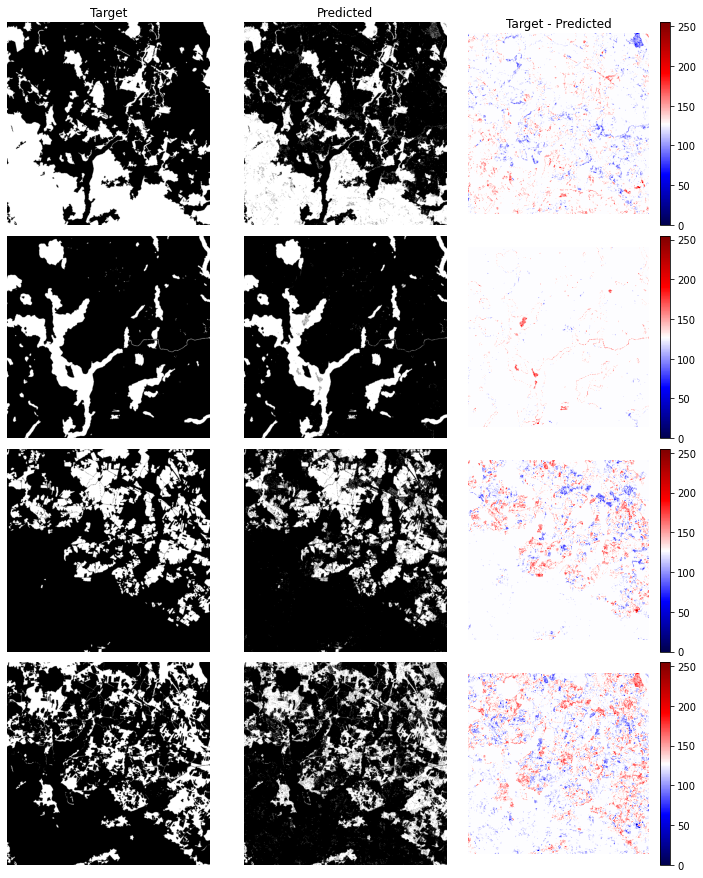

In [29]:
Y_pred_DL = model.predict(X)
Y_pred_DL = np.rint(Y_pred_DL)
hlp.show_target_pred_dif(Y.reshape(xyz), Y_pred_RF.reshape((dx, dy, nr_of_classes)))

# Klasyfikacja obszaru z wykorzystaniem samoorganizujących się map

In [30]:
from minisom import MiniSom
x_som, y_som = 4,4
som = MiniSom(x=x_som, y=y_som, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X, num_iteration=100000, verbose=False)

#### Klasyfikujemy
Każdemu punktowi możemy przypisać jeden z neuronów mapy

In [31]:
Y_pred_SOM = [som.winner(x) for x in X]
Y_pred_SOM = np.array([str(i) for i in Y_pred_SOM ])

#### One Hot Encode

In [32]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y_pred_SOM = enc.fit_transform(Y_pred_SOM.reshape(-1, 1)).toarray()

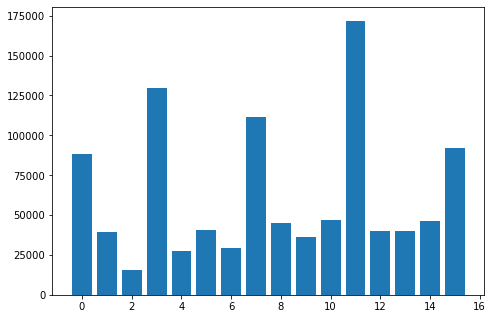

In [33]:
hlp.show_classes_distribution(Y_pred_SOM, list(range(Y_pred_SOM.shape[1])))

In [34]:
mapa = np.sum(Y_pred_SOM*som.distance_map().flatten(), axis=1)

#### rysujemy mapę

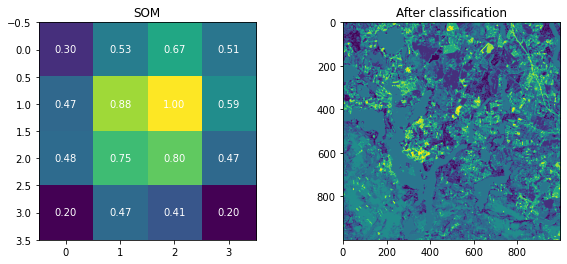

In [35]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2, nrows=1)
ax1.set_title('SOM')
ax1.imshow(som.distance_map())
for (i, j), z in np.ndenumerate(som.distance_map()):
    ax1.text(j, i, '{:0.2f}'.format(som.distance_map()[i,j]), ha='center', va='center',color = 'white')
ax2.set_title('After classification')
ax2.imshow(mapa.reshape((dx,dy)))

In [36]:
import cv2
cv2.imwrite('wynik_som.png', mapa.reshape((dx,dy))*255)

True

#### Walidacja

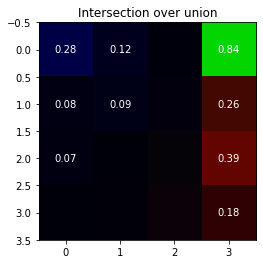

In [37]:
clusstered = np.zeros((x_som,y_som,3))
matrix_IoU = hlp.metrics_matrix(Y, Y_pred_SOM, hlp.IoU)
clusstered[...,2]=matrix_IoU[:,2].reshape((x_som,y_som))#Klasa 1 kolor niebieski
clusstered[...,1]=matrix_IoU[:,1].reshape((x_som,y_som))#Klasa 2 kolor zielony
clusstered[...,0]=matrix_IoU[:,0].reshape((x_som,y_som))#Klasa 3 kolor czerwony
fig, ax = plt.subplots()
ax.set_title('Intersection over union')
plt.imshow(clusstered)
for (i, j, k), z in np.ndenumerate(clusstered):
    if z > 0.05:
        ax.text(j, i, '{:0.2f}'.format(max(clusstered[i,j,:])), ha='center', va='center',color = 'white')

Kolorami oznaczono klasę którą reprezentują. Słabe wyniki spowodowane są dużo wyższą liczbą otrzymanych klas niż klas które mieliśmy początkowo.

In [38]:
best = [matrix_IoU[:,i].argsort()[-1] for i in range(3)]

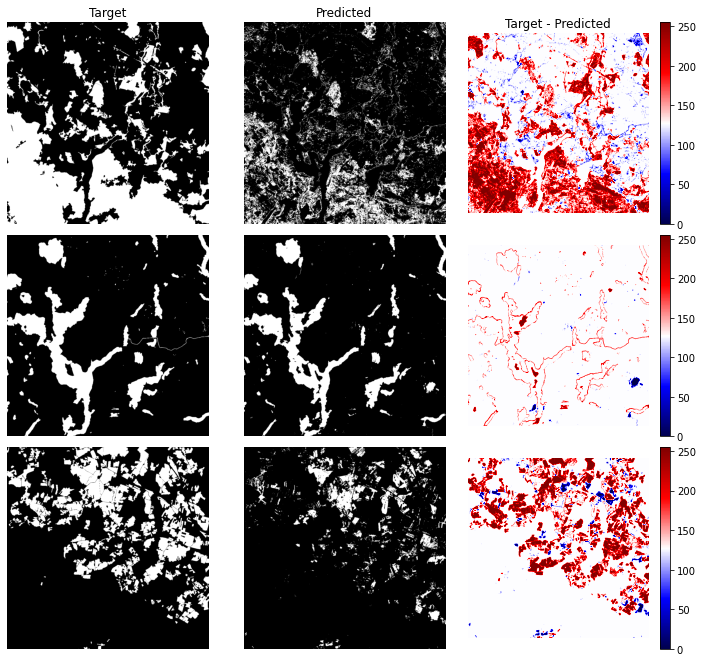

In [39]:
hlp.show_target_pred_dif(Y.reshape(xyz)[...,:-1], Y_pred_SOM.reshape((dx,dy,Y_pred_SOM.shape[1]))[...,best])

In [43]:
yt, yp = Y.reshape(xyz)[...,1],  Y_pred_RF.reshape(xyz)[...,1]
cv2.imwrite('RF.png',(yt-yp+1)*127)

True

In [44]:
yt, yp = Y.reshape(xyz)[...,1],  Y_pred_DL.reshape(xyz)[...,1]
cv2.imwrite('DL.png',(yt-yp+1)*127)

True

# Walidacja:

Jako miarę poprawności algorytmu wybrałem 
Indeks Jaccarda w skrócie IoU
$$IoU = \frac{A \cap B}{A \cup B} $$

In [50]:
IoU_DL = [hlp.IoU(Y[...,i],Y_pred_DL[...,i]) for i in range(4)]

In [51]:
IoU_RF = [hlp.IoU(Y[...,i],Y_pred_RF[...,i]) for i in range(4)]

In [70]:
validation = pd.DataFrame(columns=['model'] + classes_names)

In [78]:
validation.loc[0]=(['DL']+[hlp.IoU(Y[...,i],Y_pred_DL[...,i]) for i in range(4)])
validation.loc[1]=(['RF']+[hlp.IoU(Y[...,i],Y_pred_RF[...,i]) for i in range(4)])
validation

,model,forests_20m,water_20m,farmland_20m,other
0,DL,0.801844,0.885515,0.57233,0.463567
1,RF,0.944477,0.970444,0.876535,0.830487
